# Introdução

Neste trabalho procuramos criar um algoritmo **Algoritmo Evolucionário** para a resolução do problema das **N Rainhas**. O processo de descrição da construção do algoritmo, bem como as escolhas de parâmetros, serão descritos em detalhes para cada sessão do algoritmo.

A forma do algoritmo final se baseia no pseudocódigo fornecido na descrição do trabalho, sendo ele o seguinte:

<code>
BEGIN
	INITIALISE population with random candidate solutions;
	EVALUATE each candidate;
	REPEAT UNTIL ( TERMINATION CONDITION is satisfied ) DO
		1 SELECT parents;
		2 RECOMBINE pairs of parents;
		3 MUTATE the resulting offspring;
		4 EVALUATE new candidates;
		5 SELECT individuals for the next generation;
	OD
END
<code>

In [1]:
import random as rd
import numpy as np
import matplotlib.pyplot as plt

# Criação da População e Parâmetros

Para iniciar a **população**, por meio da representação exigida no relatório, será gerada aleatoriamente uma população de tamanho decidido arbitrariamente, em que cada indivíduo possui um número n de rainhas (uma para cade linha do tabuleiro). Além disso, como exigido foram definidas as taxas de mutação (80%) e o limite máximo de gerações (10.000).

> Obs: O programa leva em torno de uma hora para resolver todas as soluções analisadas, caso uma análise mais veloz seja necessária basta alterar o valor de max_generations para 1000.

In [2]:
crossover_rate = 1
mutation_rate = 0.8 
max_generations = 10000 # O Máximo de gerações permitidas, valor definido pelo poder computacional limitado

def init_population(_mu:int = 20, n:int = 8):
    population = []
    for i in range (_mu):
        population.append(rd.sample(range(n), n))
    return population

# Função de Aptidão

Definimos a **aptidão** como o número de xeques que as rainhas estão expostas. Vale notar que o objetivo do problema é **minimizar** a função de aptidão, para termos o menor número de xeques possíveis e, se possível, nenhum.

In [3]:
def fitness_nq(solution):
    xeques = 0
    for i in range(0,len(solution)):
        for j in range(0,len(solution)):
            if i!=j:
                if i-solution[i] == j-solution[j] or i+solution[i] == j+solution[j]:
                    xeques+=1
    return xeques

# Mutação da Solução

Realizamos a **mutação** utilizando a técnica de **Swap**. Para isso, escolhemos aleatoriamente duas posições do vetor de representação do indivíduo e trocamos seus valores.
> **Exemplo:** Caso tenhamos escolhido as posições 2 e 4 para o vetor [0,1,2,3,4,5,6,7], teremos a mutação [0,1,4,3,2,5,6,7].

In [4]:
def mutate_solution(solution):
    to_swap_lines = rd.sample(range(0,len(solution)), 2)
    solution[to_swap_lines[0]], solution[to_swap_lines[1]] = solution[to_swap_lines[1]], solution[to_swap_lines[0]]

# Recombinação

Realizamos a **recombinação** utilizando a técnica de **Cut-and-crossﬁll**. Esse método irá criar dois filhos, cada um deles irá possuir uma parte inicial do vetor de um pai e irá 'retirar' os outros valores, que ainda não possui, do outro pai.

> Obs: As explicações de cada parte da técnica utilizada podem ser encontradas nos comentários dentro da própria função presente abaixo

In [5]:
def recombine(population):
    # Escolha de 5 possíveis pais aleatoriamente
    random_possible_parents = [population[i] for i in rd.sample(range(0,len(population)), 5)]

    # Melhores duas possíveis soluções para pais
    best_possible_parents_indexes = np.argpartition([fitness_nq(sol) for sol in random_possible_parents] ,2)[:2]
    parent_1 = random_possible_parents[best_possible_parents_indexes[0]]
    parent_2 = random_possible_parents[best_possible_parents_indexes[1]]
    
    # Ter ao menos 1 elemento de cada pai para cada filho e preencher os filhos (inicialmente)
    first_section_cut_index = rd.choice(range(0, len(parent_1)-1))
    
    child_1 = np.zeros(len(parent_1))
    child_2 = np.zeros(len(parent_2))
    
    child_1[:first_section_cut_index+1] = parent_1[:first_section_cut_index+1]
    child_2[:first_section_cut_index+1] = parent_2[:first_section_cut_index+1]
    
    # Preenchendo o resto dos vetores filhos com as soluções dos próximos pais
    current_child_index = first_section_cut_index
    
    for value in parent_2:
        if current_child_index >= len(child_1)-1:
            break
        if value in child_1:
            continue
            
        child_1[current_child_index+1] = value
            
        current_child_index += 1
        
        
    current_child_index = first_section_cut_index
        
    for value in parent_1:
        if current_child_index >= len(child_2)-1:
            break
        if value in child_2:
            continue
            
        child_2[current_child_index+1] = value
            
        current_child_index += 1
        
    child_1 = [int(x) for x in child_1]
    child_2 = [int(x) for x in child_2]
        
    return child_1, child_2



# Escolha de Mutações

Realizamos com **80%** de chance a **mutação** para cada um dos dois filhos.

In [7]:
def mutate_childs(child_1, child_2):
    # Mutações em 80% das vezes para cada filho
    
    if rd.uniform(0, 1) < mutation_rate:
        mutate_solution(child_1)
        
    if rd.uniform(0, 1) < mutation_rate:
        mutate_solution(child_2)

# Seleção de Candidatos

A **população** que continuará será referente aos n-2 indivíduos, após a inserção dos 2 filhos, que melhor se adaptam ao problema, ou seja, os 2  indivíduos com os piores valores de aptidão serão retirados da população.

In [9]:
def select_new_population(pop, child_1, child_2):
    # Retirando piores duas soluções da nova população
    
    pop.append(child_1)
    pop.append(child_2)
    
    elements_indexes_to_pop = np.argpartition([fitness_nq(sol) for sol in pop], -2)[-2:]
    
    for index in sorted(elements_indexes_to_pop, reverse=True):
        del pop[index]
    
    return pop

# Encontrar a Solução
Uma função que nos permite realizar o processo de um **Algoritmo Evolucionário** de forma simples, sendo necessário escolher apenas a quantidade de indivíduos na população e quantas rainhas devem existir no tabuleiro. O formato do código se baseia no pseudocódigo descrito na Introdução.

In [10]:
def find_best_solution(_mu, n):
    pop = init_population(_mu, n)

    current_generation = 0
    fitness_pop_vectors = []

    while True:
        fitness_pop = [fitness_nq(sol) for sol in pop]
        fitness_pop_vectors.append(min(fitness_pop))

        if 0 in fitness_pop or current_generation >= max_generations:
            break

        child_1, child_2 = recombine(pop)

        mutate_childs(child_1, child_2)

        pop = select_new_population(pop, child_1, child_2)

        current_generation += 1

    best_solution = pop[np.argmin([fitness_nq(sol) for sol in pop])]
    
    best_solution_fitness = fitness_nq(best_solution)
    
    return best_solution, best_solution_fitness, current_generation, fitness_pop_vectors

A Melhor sulução Encontrada para 8 rainhas com 20 indivíduos na população foi [7, 1, 3, 0, 6, 4, 2, 5] com aptidão de 0 na geração 21.


A Melhor sulução Encontrada para 8 rainhas com 50 indivíduos na população foi [4, 0, 7, 3, 1, 6, 2, 5] com aptidão de 0 na geração 68.


A Melhor sulução Encontrada para 8 rainhas com 100 indivíduos na população foi [3, 6, 0, 7, 4, 1, 5, 2] com aptidão de 0 na geração 48.




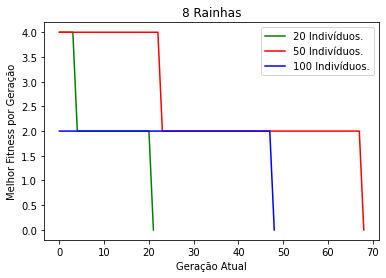

In [11]:
best_solution, best_solution_fitness, current_generation, fitness_pop_vectors = find_best_solution(20, 8)
print(f'A Melhor sulução Encontrada para 8 rainhas com 20 indivíduos na população foi {best_solution} com aptidão de {best_solution_fitness} na geração {current_generation}.\n\n')
plt.plot(fitness_pop_vectors, color='green', label="20 Indivíduos.")

best_solution, best_solution_fitness, current_generation, fitness_pop_vectors = find_best_solution(50, 8)
print(f'A Melhor sulução Encontrada para 8 rainhas com 50 indivíduos na população foi {best_solution} com aptidão de {best_solution_fitness} na geração {current_generation}.\n\n')
plt.plot(fitness_pop_vectors, color='red', label="50 Indivíduos.")

best_solution, best_solution_fitness, current_generation, fitness_pop_vectors = find_best_solution(100, 8)
print(f'A Melhor sulução Encontrada para 8 rainhas com 100 indivíduos na população foi {best_solution} com aptidão de {best_solution_fitness} na geração {current_generation}.\n\n')
plt.plot(fitness_pop_vectors, color='blue', label="100 Indivíduos.")

plt.ylabel('Melhor Fitness por Geração')
plt.xlabel('Geração Atual')
plt.title('8 Rainhas')
plt.legend()
plt.show()

A Melhor sulução Encontrada para 20 rainhas com 20 indivíduos na população foi [12, 3, 16, 8, 19, 11, 1, 6, 0, 13, 17, 9, 2, 4, 7, 15, 10, 18, 14, 5] com aptidão de 0 na geração 811.


A Melhor sulução Encontrada para 20 rainhas com 50 indivíduos na população foi [6, 0, 13, 10, 18, 7, 14, 4, 1, 9, 19, 3, 16, 11, 17, 2, 5, 8, 12, 15] com aptidão de 0 na geração 2342.


A Melhor sulução Encontrada para 20 rainhas com 100 indivíduos na população foi [10, 4, 16, 12, 8, 6, 17, 1, 14, 5, 18, 13, 19, 3, 7, 2, 11, 9, 15, 0] com aptidão de 0 na geração 2961.




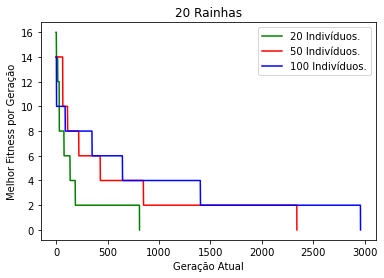

In [12]:
best_solution, best_solution_fitness, current_generation, fitness_pop_vectors = find_best_solution(20, 20)
print(f'A Melhor sulução Encontrada para 20 rainhas com 20 indivíduos na população foi {best_solution} com aptidão de {best_solution_fitness} na geração {current_generation}.\n\n')
plt.plot(fitness_pop_vectors, color='green', label="20 Indivíduos.")

best_solution, best_solution_fitness, current_generation, fitness_pop_vectors = find_best_solution(50, 20)
print(f'A Melhor sulução Encontrada para 20 rainhas com 50 indivíduos na população foi {best_solution} com aptidão de {best_solution_fitness} na geração {current_generation}.\n\n')
plt.plot(fitness_pop_vectors, color='red', label="50 Indivíduos.")

best_solution, best_solution_fitness, current_generation, fitness_pop_vectors = find_best_solution(100, 20)
print(f'A Melhor sulução Encontrada para 20 rainhas com 100 indivíduos na população foi {best_solution} com aptidão de {best_solution_fitness} na geração {current_generation}.\n\n')
plt.plot(fitness_pop_vectors, color='blue', label="100 Indivíduos.")

plt.ylabel('Melhor Fitness por Geração')
plt.xlabel('Geração Atual')
plt.title('20 Rainhas')
plt.legend()
plt.show()

A Melhor sulução Encontrada para 50 rainhas com 20 indivíduos na população foi [28, 15, 21, 35, 49, 25, 0, 18, 4, 8, 46, 13, 29, 1, 26, 42, 5, 32, 44, 48, 23, 39, 14, 3, 11, 20, 24, 27, 9, 30, 43, 17, 40, 37, 12, 45, 41, 7, 31, 36, 47, 10, 19, 22, 34, 2, 6, 38, 16, 33] com aptidão de 0 na geração 904.


A Melhor sulução Encontrada para 50 rainhas com 50 indivíduos na população foi [18, 23, 7, 26, 32, 35, 17, 4, 40, 1, 24, 49, 38, 19, 3, 22, 47, 10, 37, 34, 6, 41, 16, 31, 45, 20, 13, 44, 2, 12, 14, 27, 11, 42, 46, 33, 21, 28, 9, 39, 43, 5, 0, 8, 48, 25, 15, 29, 36, 30] com aptidão de 0 na geração 8782.


A Melhor sulução Encontrada para 50 rainhas com 100 indivíduos na população foi [42, 35, 30, 47, 18, 26, 49, 10, 21, 16, 43, 3, 29, 8, 19, 45, 22, 13, 27, 38, 6, 31, 48, 46, 32, 1, 41, 17, 12, 33, 7, 20, 14, 2, 25, 28, 37, 11, 36, 4, 39, 24, 5, 15, 44, 9, 40, 34, 23, 0] com aptidão de 2 na geração 10000.




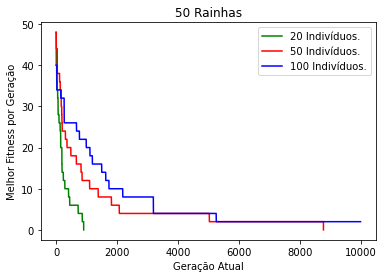

In [13]:
best_solution, best_solution_fitness, current_generation, fitness_pop_vectors = find_best_solution(20, 50)
print(f'A Melhor sulução Encontrada para 50 rainhas com 20 indivíduos na população foi {best_solution} com aptidão de {best_solution_fitness} na geração {current_generation}.\n\n')
plt.plot(fitness_pop_vectors, color='green', label="20 Indivíduos.")

best_solution, best_solution_fitness, current_generation, fitness_pop_vectors = find_best_solution(50, 50)
print(f'A Melhor sulução Encontrada para 50 rainhas com 50 indivíduos na população foi {best_solution} com aptidão de {best_solution_fitness} na geração {current_generation}.\n\n')
plt.plot(fitness_pop_vectors, color='red', label="50 Indivíduos.")

best_solution, best_solution_fitness, current_generation, fitness_pop_vectors = find_best_solution(100, 50)
print(f'A Melhor sulução Encontrada para 50 rainhas com 100 indivíduos na população foi {best_solution} com aptidão de {best_solution_fitness} na geração {current_generation}.\n\n')
plt.plot(fitness_pop_vectors, color='blue', label="100 Indivíduos.")

plt.ylabel('Melhor Fitness por Geração')
plt.xlabel('Geração Atual')
plt.title('50 Rainhas')
plt.legend()
plt.show()

# Conclusão

Podemos notar que as técnicas de mutação e recombinação utilizadas não são eficientes para problemas de alta complexidade (e.g. mais que 50 rainhas), sendo uma boa ideia utilizar outras heurísticas  para problemas mais complexos que o aqui apresentado.

Apesar de não ser possível realizar uma comparação puramente objetiva devido à aleatoriedade do problema, de forma geral é notório o fato de uma população muito extensa não ser a melhor forma de resolver o problema, sendo muitas vezes apenas um fator de aumento de complexidade computacional sem real valor no contexto da otimização.

Outros pontos que merecem ser mencionados referem-se ao fato de a população estática atrapalhar a melhoria do espaço de busca quando temos muitos indivíduos, sendo uma possibilidade uma população de tamanho variável ao passar do tempo ou uma população que tenha mutações em mais indivíduos/tenha mais filhos.